<a href="https://colab.research.google.com/github/Se1towo/IMLO_Exam/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
import csv
import os
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
!pip install torchinfo
from tqdm import tqdm
from torchinfo import summary

In [17]:
plt.style.use('ggplot')

if not os.path.exists("outputs"):
    os.makedirs("outputs")

# Initialize early stopping parameters
best_loss = float('inf')
patience = 10


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, 'outputs/best_model.pth')

In [18]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/final_model.pth')

In [19]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [20]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
])

train_resize_crop = transforms.Compose([transforms.RandomResizedCrop(150), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_center_crop = transforms.Compose([transforms.CenterCrop(100), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_h_flip = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_v_flip = transforms.Compose([transforms.RandomVerticalFlip(), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_grayscale = transforms.Compose([transforms.RandomGrayscale(p=0.1), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_colorjitter = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_perspective = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.5, p=0.5), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_rotation = transforms.Compose([transforms.RandomRotation(45), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_blur = transforms.Compose([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), transforms.Resize((150,150)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [21]:
plain_set = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)
print("Training data:", plain_set)

Training data: Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [22]:
rc_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_resize_crop)
cc_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_center_crop)
hf_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_h_flip)
vf_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_v_flip)
gs_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_grayscale)
cj_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_colorjitter)
ps_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_perspective)
rt_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_rotation)
br_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_blur)

training_data = torch.utils.data.ConcatDataset([rc_set, cc_set, hf_set, vf_set, gs_set, cj_set, ps_set, rt_set, br_set, plain_set])
print("Training data:", training_data)

Training data: <torch.utils.data.dataset.ConcatDataset object at 0x7d40dc419030>


In [23]:
test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)
print("Testing data:", test_data)

validation_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=transform
)
print("Validation data:", validation_data)

Testing data: Dataset Flowers102
    Number of datapoints: 6149
    Root location: data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Validation data: Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [24]:
learning_rate = 1e-4 #maybe decrease though
batch_size = 64
epochs = 100

In [25]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)

In [26]:
train_dataset_size = len(training_data)

<ipython-input-27-8f16292b5e7b>:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(img.squeeze().T)


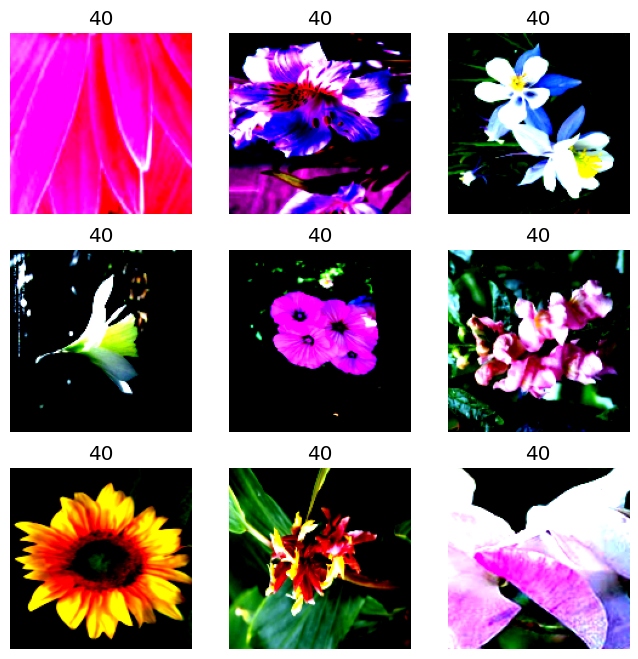

In [27]:
# 9 sample images from training dataset
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i % len(labels_map)]) #works when rerun
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

Feature batch shape: torch.Size([64, 3, 150, 150])
Labels batch shape: torch.Size([64])


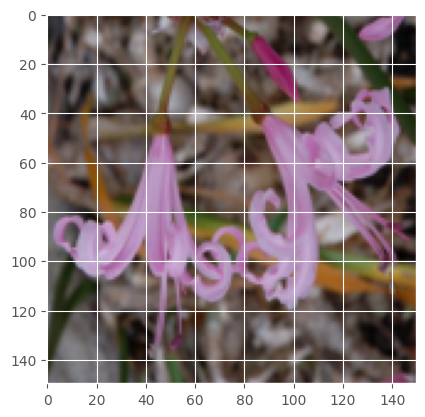

Label: 36


In [28]:
# Example training image
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T.squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [30]:
#import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pooling_stack = nn.Sequential(
            # Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(20),
            # Activation Layer
            nn.ReLU(inplace=True),
            # Pooling Layer
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(20, 40, kernel_size=5, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(40, 80, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(80),
            nn.LeakyReLU(inplace=True),

            # nn.Conv2d(80, 80, kernel_size=3, padding=1),
            # Batch Normalization
            # nn.BatchNorm2d(80),
            # nn.LeakyReLU(inplace=True),

            nn.Conv2d(80, 80, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(80),
            nn.LeakyReLU(inplace=True),

            # nn.Conv2d(80, 80, kernel_size=3, padding=1),
            # # Batch Normalization
            # nn.BatchNorm2d(80),
            # nn.LeakyReLU(inplace=True),

            nn.Conv2d(80, 40, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            # Fully connected layers
            nn.Linear(11560, 4096),
            nn.LeakyReLU(inplace=True),
            # Regularization
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Regularization
            nn.Dropout(0.5),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.conv_pooling_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [31]:
model = NeuralNetwork().to(device)
# print(model)
print(f"Summary:\n{summary(model, input_size=(batch_size, 3, 150, 150))}")

Summary:
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 102]                 --
├─Sequential: 1-1                        [64, 40, 17, 17]          --
│    └─Conv2d: 2-1                       [64, 20, 150, 150]        560
│    └─BatchNorm2d: 2-2                  [64, 20, 150, 150]        40
│    └─ReLU: 2-3                         [64, 20, 150, 150]        --
│    └─MaxPool2d: 2-4                    [64, 20, 74, 74]          --
│    └─Conv2d: 2-5                       [64, 40, 72, 72]          20,040
│    └─BatchNorm2d: 2-6                  [64, 40, 72, 72]          80
│    └─ReLU: 2-7                         [64, 40, 72, 72]          --
│    └─MaxPool2d: 2-8                    [64, 40, 35, 35]          --
│    └─Conv2d: 2-9                       [64, 80, 35, 35]          28,880
│    └─BatchNorm2d: 2-10                 [64, 80, 35, 35]          160
│    └─LeakyReLU: 2-11                   [64, 80, 35, 35]         

In [32]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        correct += (pred.argmax(1) == y).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_accuracy = 100.0 * correct / size
    print(f"Training Accuracy: {train_accuracy:.2f}%\n")
    return loss, train_accuracy


def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    val_loss /= batch_size
    val_accuracy = 100.0 * correct / size
    print(f"Validation Error: \n Accuracy: {val_accuracy:>0.2f}%, Validation loss: {val_loss:>8f} \n")
    return val_loss, val_accuracy

Epoch 1
-------------------------------
Training loss: 4.673912  [   64/10200]
Training loss: 4.041978  [ 6464/10200]
Training Accuracy: 5.46%

Validation Error: 
 Accuracy: 6.34%, Validation loss: 6.231444 


Best validation loss: 6.231444075703621

Saving best model for epoch: 1

Epoch 2
-------------------------------
Training loss: 3.885238  [   64/10200]
Training loss: 3.363391  [ 6464/10200]
Training Accuracy: 18.66%

Validation Error: 
 Accuracy: 9.22%, Validation loss: 5.774371 


Best validation loss: 5.774370916187763

Saving best model for epoch: 2

Epoch 3
-------------------------------
Training loss: 3.161742  [   64/10200]
Training loss: 2.695865  [ 6464/10200]
Training Accuracy: 33.92%

Validation Error: 
 Accuracy: 15.12%, Validation loss: 5.230738 


Best validation loss: 5.230737514793873

Saving best model for epoch: 3

Epoch 4
-------------------------------
Training loss: 2.100440  [   64/10200]
Training loss: 2.105768  [ 6464/10200]
Training Accuracy: 47.66%

Val

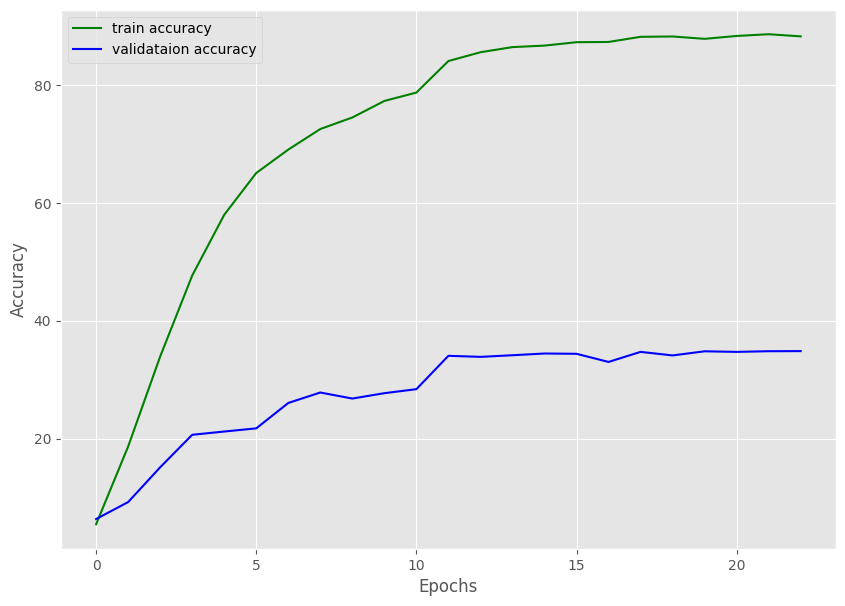

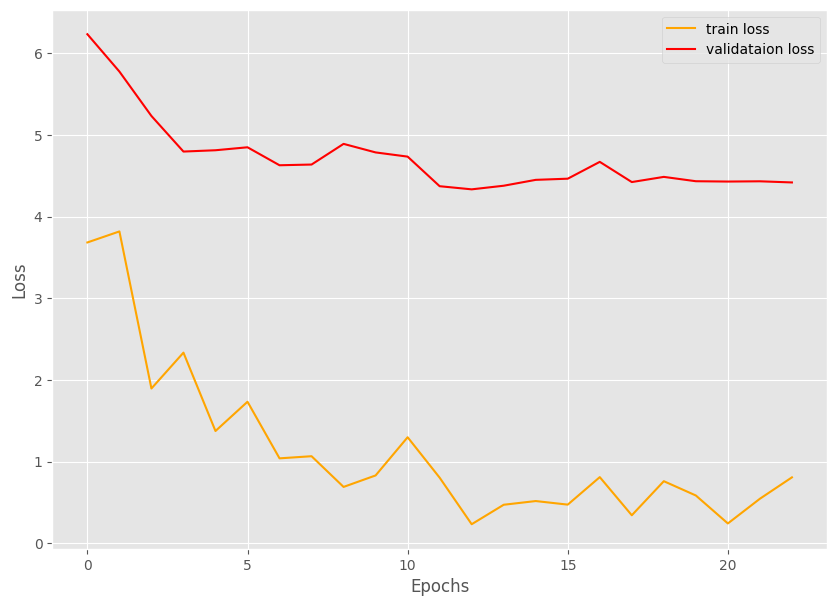

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
save_best_model = SaveBestModel()

# lists to keep track of losses and accuracies
train_l, valid_l = [], []
train_acc, valid_acc = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    valid_loss, val_accuracy = val_loop(test_dataloader, model, loss_fn)

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(valid_loss, t, model, optimizer, loss_fn)
    train_l.append(train_loss.cpu().detach().numpy())
    valid_l.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(val_accuracy)

    # Scheduler learning rate mitigation
    scheduler.step(valid_loss)

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
        patience = 10  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping triggered!")
            break

# save the trained model weights for a final time
save_model(epochs, model, optimizer, loss_fn)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_l, valid_l)
print("Done!")

In [20]:
#Testing best model

# build the model, no need to load the pre-trained weights or fine-tune layers
model = NeuralNetwork().to(device)
# load the best model checkpoint
best_model_cp = torch.load('outputs/best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
# load the last model checkpoint
last_model_cp = torch.load('outputs/final_model.pth')
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")

# get the test dataset and the test data loader
#Training
training_data = datasets.Flowers102(root="data",split="train",download=True,
    transform=transform
)
rc_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_resize_crop)
cc_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_center_crop)
hf_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_h_flip)
vf_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_v_flip)
gs_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_grayscale)
cj_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_colorjitter)
ps_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_perspective)
rt_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_rotation)
br_set = datasets.Flowers102(root="data",split="train", download=True,
    transform=train_blur)
training_data = torch.utils.data.ConcatDataset([rc_set, cc_set, hf_set, vf_set, gs_set, cj_set, ps_set, rt_set, br_set, plain_set])

#Test and validation
test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)

validation_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=transform
)
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)

Best model was saved at 13 epochs

Last model was saved at 100 epochs



In [21]:
!pip install torchinfo
from tqdm import tqdm
from torchinfo import summary
def test(model, testloader):
    """
    Function to test the model
    """
    # set model to evaluation mode
    model.eval()
    print('Testing')
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    final_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return final_acc

# test the last epoch saved model
def test_last_model(model, checkpoint, test_loader):
    print('Loading last epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc = test(model, test_loader)
    print(f"Summary: {summary(model, input_size=(batch_size, 3, 150, 150))}")
    print(f"Last epoch saved model accuracy: {test_acc:.3f}\n")
# test the best epoch saved model
def test_best_model(model, checkpoint, test_loader):
    print('Loading best epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc = test(model, test_loader)
    print(f"Summary: {summary(model, input_size=(batch_size, 3, 150, 150))}")
    print(f"Best epoch saved model accuracy: {test_acc:.3f}")

In [22]:
test_last_model(model, last_model_cp, test_dataloader)
test_best_model(model, best_model_cp, test_dataloader)

Loading last epoch saved model weights...
Testing


100%|██████████| 97/97 [00:39<00:00,  2.45it/s]


Summary: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 102]                 --
├─Sequential: 1-1                        [64, 40, 17, 17]          --
│    └─Conv2d: 2-1                       [64, 20, 150, 150]        560
│    └─BatchNorm2d: 2-2                  [64, 20, 150, 150]        40
│    └─ReLU: 2-3                         [64, 20, 150, 150]        --
│    └─MaxPool2d: 2-4                    [64, 20, 74, 74]          --
│    └─Conv2d: 2-5                       [64, 40, 72, 72]          20,040
│    └─BatchNorm2d: 2-6                  [64, 40, 72, 72]          80
│    └─ReLU: 2-7                         [64, 40, 72, 72]          --
│    └─MaxPool2d: 2-8                    [64, 40, 35, 35]          --
│    └─Conv2d: 2-9                       [64, 80, 35, 35]          28,880
│    └─BatchNorm2d: 2-10                 [64, 

100%|██████████| 97/97 [00:30<00:00,  3.20it/s]

Summary: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 102]                 --
├─Sequential: 1-1                        [64, 40, 17, 17]          --
│    └─Conv2d: 2-1                       [64, 20, 150, 150]        560
│    └─BatchNorm2d: 2-2                  [64, 20, 150, 150]        40
│    └─ReLU: 2-3                         [64, 20, 150, 150]        --
│    └─MaxPool2d: 2-4                    [64, 20, 74, 74]          --
│    └─Conv2d: 2-5                       [64, 40, 72, 72]          20,040
│    └─BatchNorm2d: 2-6                  [64, 40, 72, 72]          80
│    └─ReLU: 2-7                         [64, 40, 72, 72]          --
│    └─MaxPool2d: 2-8                    [64, 40, 35, 35]          --
│    └─Conv2d: 2-9                       [64, 80, 35, 35]          28,880
│    └─BatchNorm2d: 2-10                 [64, 

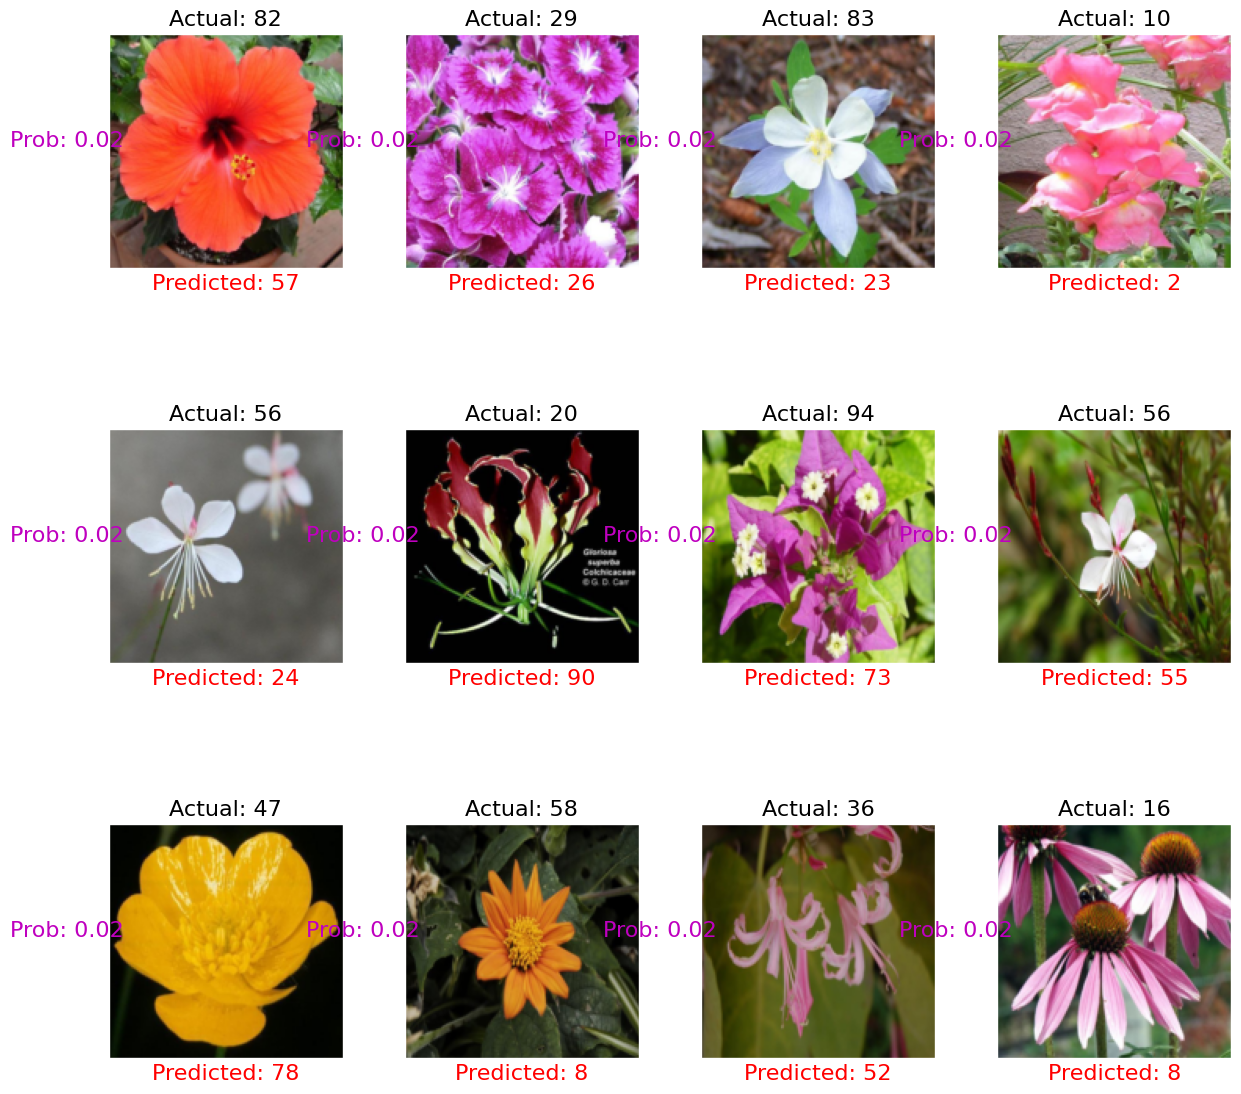

In [45]:
# Predictions for 9 sample images from testing dataset
figure, ax = plt.subplots(3, 4, figsize=(12, 12))
figure.tight_layout()

i = 0
for R in range(3):
    for C in range(4):
        # Randomly select a sample from the test dataset
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]

        # Predict the label for the selected sample
        img = img.to(device)
        output = F.softmax(model(img.unsqueeze(0)), dim=-1)
        pred_value, pred_label = output.max(-1)

        # # Move the image and label back to the CPU for visualization
        # img = img.cpu()
        # label = label.cpu()
        # pred_label = pred_label.cpu()

        # Plot the image
        ax[R, C].imshow(torch.clamp(img, min=0, max=1).permute(1, 2, 0), cmap='Greys_r')
        ax[R, C].set_title('Actual: ' + str(label), fontsize=16).set_color('k')  # Actual labels
        if label == pred_label:
            ax[R, C].set_xlabel('Predicted: ' + pred_label, fontsize=16).set_color('b')  # Correct predictions
        else:
            ax[R, C].set_xlabel('Predicted: ' + str(pred_label.item()), fontsize=16).set_color('r')  # Wrong predictions
        ax[R, C].set_ylabel(f'Prob: {pred_value.item():.2f}', fontsize=16, rotation=0, labelpad=30).set_color('m')  # Probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

plt.show()

In [41]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,3,150,150), expand_nested=True)
model_graph.visual_graph
model_graph.resize_graph(scale=5.0) # scale as per the view
model_graph.visual_graph.render(format='png')

'model.gv.png'

In [39]:
!pip install torchviz
from torchviz import make_dot

input_tensor = torch.randn(1, 3, 150, 150)
output_tensor = model(input_tensor)

make_dot(output_tensor, params=dict(list(model.named_parameters()))).render("architecture", format="png")

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

'architecture.png'